In [1]:
25/32

0.78125

In [2]:
32/25

1.28

In [3]:
# import numpy and exp mat
import os
import numpy as np
import matplotlib.pyplot as plt

from module.QuantumSystem import SHOscillator
from module.Walker import MetropolisWalker
from module.Utils import VMC

from joblib import Parallel, delayed

import time

np.random.seed(0)

# Spherical Harmonic Oscillator without interaction, with Metropolis and analytical hamiltonian
In this notebook we study the Spherical Harmonic Oscillator without interaction, using the Metropolis algorithm and analytical hamiltonian.

In the first section we study the scaling of the execution time and the std of the mean energy (for an non optimal variational parameter) as function of the dimension of the system and the number of particles and fixed sampling steps.

## Grid search
In this section we perform a grid search of $\alpha$ for fixed N and D.
In particular we save the mean energy, the std of the mean energy and the time of execution for each $\alpha$ then we plot the results.

During a grid search warmup plot of the energies and the blocking plot are saved in a directory, so one can always check if the results are rasonable.

In [4]:
params = np.array([0.6])

run_steps = np.array([100000, 200000, 1000000, 2000000, 10000000])
warmup_steps = 0.1 * 0.5 * run_steps 
warmup_steps = warmup_steps.astype(int)
calibrate_steps = 0.1 * 0.5 * run_steps
calibrate_steps = calibrate_steps.astype(int)
batch_steps = 0.1 * calibrate_steps
batch_steps = batch_steps.astype(int)

vanilla_times = np.zeros(run_steps.size)
vanilla_energy = np.zeros(run_steps.size)
vanilla_energy_std = np.zeros(run_steps.size)

In [5]:
# for each run_steps measure the time and energy and energy std
for i, steps in enumerate(run_steps):
    N = 20
    D = 3
    system = SHOscillator(N, D, params)
    walker = MetropolisWalker(system)
    vmc = VMC(system, walker, params, 
            warmup_steps=warmup_steps[i], run_steps=run_steps[i], 
            calibrate_steps=calibrate_steps[i], batch_steps=batch_steps[i], acceptance_rate=0.5,
            block_quantiles=0.8, plot=False, verbose=False)
    start = time.time()
    vmc.calibrate()
    vmc.warmup()
    vmc.run()
    vanilla_times[i] = time.time() - start
    vanilla_energy[i] = vmc.get_energy()
    vanilla_energy_std[i] = vmc.get_energy_std()

In [6]:
def run_simulation(seed, n_jobs, run_steps, warmup_steps, calibrate_steps, batch_steps):
    np.random.seed(seed)
    run_steps = int(run_steps/n_jobs)
    warmup_steps = int(warmup_steps/n_jobs)
    calibrate_steps = int(calibrate_steps/n_jobs)
    batch_steps = int(batch_steps/n_jobs)
    system = SHOscillator(N, D, params)
    walker = MetropolisWalker(system)
    vmc = VMC(system, walker, params, 
              warmup_steps=warmup_steps, run_steps=run_steps, 
              calibrate_steps=calibrate_steps, batch_steps=batch_steps,acceptance_rate=0.5,
              block_quantiles=0.8, plot=False, verbose=False)
    vmc.calibrate()
    vmc.warmup()
    vmc.run()
    return vmc.get_energy(), vmc.get_energy_std()

In [7]:
# again but this time paralleling the runs
os.system('mkdir -p results/Parallelization')
data = []
n_jobs = 8

parallel_times = np.zeros(run_steps.size)

for i, steps in enumerate(run_steps):
    seeds = np.random.randint(0, 1000000, n_jobs)

    results = Parallel(n_jobs=n_jobs)(delayed(run_simulation)(seed,n_jobs, run_steps[i], warmup_steps[i], calibrate_steps[i], batch_steps[i]) for seed in seeds)
    start = time.time()
    results = Parallel(n_jobs=n_jobs)(delayed(run_simulation)(seed,n_jobs, run_steps[i], warmup_steps[i], calibrate_steps[i], batch_steps[i]) for seed in seeds)
    parallel_times[i] = time.time() - start
    data.append(results)

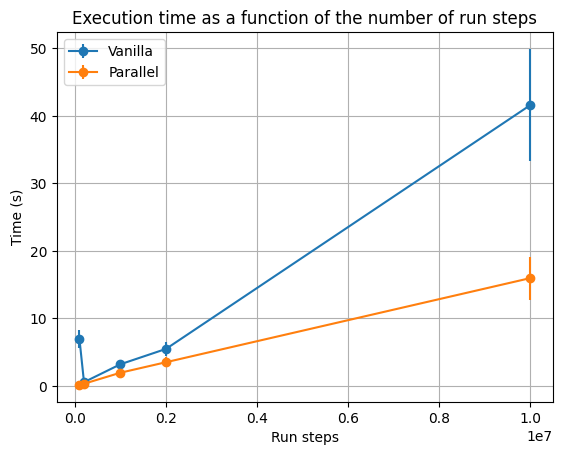

In [10]:
# make an errorbar with 20% of the value
plt.figure()
plt.errorbar(run_steps, vanilla_times, yerr=0.2*vanilla_times, label='Vanilla', marker='o')
plt.errorbar(run_steps, parallel_times, yerr=0.2*parallel_times, label='Parallel', marker='o')
plt.xlabel('Run steps')
plt.ylabel('Time (s)')
plt.title('Execution time as a function of the number of run steps')
# legend on the left
plt.legend(loc='upper left')
plt.grid()
plt.savefig('results/Parallelization/times_errorbar.png')


## Speedup

In [11]:
# get the ratio of the last times
ratio = vanilla_times[-1]/parallel_times[-1]
print('Speedup ratio:', ratio)

Speedup ratio: 2.6056298305825183


## Compare results
We compare the mean energy obtained with the vanilla method and the parallel one for the biggest number of step.

In [19]:
data[-1]
data = np.array(data)
parallel_energies = data[-1,:,0]

In [27]:
# get mean and std/np.sqrt(len(parallel_energies))
mean = np.mean(parallel_energies)
std = np.std(parallel_energies)/np.sqrt(len(parallel_energies))
# print
print('Vanilla energy:', vanilla_energy[-1], '+-', vanilla_energy_std[-1])
print('Parallel energy:', mean, '+-', std)

Vanilla energy: 30.48571426025815 +- 0.016184866355025168
Parallel energy: 30.51688421813147 +- 0.017095038733952208
